# Der Versuch einer Vorhersage

Wir versuchen hier eine Vorhersage zur Speicherung von CO2 zu geben.  
Die Grundlage für der Berechnung ist:

 * Die Bodenaufbereitung als Terra Preta
 * Die Pflanzung von Gilden aus mehrjärigen Pflanzen und Bäumen

## Die Kalkulation 
not visible

In [166]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import date
from datetime import timedelta

#from numericalunits import mL, nm



## Die Konstanten

Die Konstanten der Kalkulation. Wir setzen hier die Werte für das Volumengewicht und die CO2 Speicherung

Konstanten:
 * das Gewicht eines Kubikmeter Holzkohle
 * Gewicht eines Kubikmeter Kompost
 * Carbon zu CO2 Faktor
 * CO2 Gehalt in Holkohle
 * CO2 Gehalt in Holz
 * CO2 Gehalt von Pflanzen Material

In [167]:
KOHLEKGPERM3 = 0.2 * 1000 * 1000 / 1000 # Rohdichte 0.15 - 0.4 g/ccm
KOMPOSTKGPERM3 = 730

MOLGEWICHT_C = 12 # Molekular Gewicht Kohlenstoff
MOLGEWICHT_O = 16 # Molekular Gewicht Sauerstoff
MOLGEWICHT_CO2 = MOLGEWICHT_C + 2 * MOLGEWICHT_O # Molekular Gewicht CO2

FAKTORCARBONCO2 = MOLGEWICHT_CO2 / MOLGEWICHT_C # Verhältnis CO2 zu Kohlenstoff (3.7) 

KOHLECO2PERKG = FAKTORCARBONCO2 * 0.85 # Holzkohle besteht zu 81%-90% aus Kohlenstoff
HOLZCO2PERKG = FAKTORCARBONCO2 * 0.5 # Gespeichertes CO2 in Holz
PFLANZECO2PERKG = FAKTORCARBONCO2 * 0.3 # Gespeichertes CO2 in Pflanzen
KOMPOSTCO2PERKG = FAKTORCARBONCO2 * 0.15 # Gespeichertes CO2 in Kompost

In [168]:
# Verhältnis Holz zu Kohle

raumReduktionHolzZuKohle = 1 * 0.7
holzKgPerM3 = 700 # Buche, Rubunie(650-800 kg/m3), Laerche (400-800 kg/m3)

gewichtsReduktionHolzZuKohle =  KOHLEKGPERM3 / holzKgPerM3



## Erzeugung einer 10 Jahres Vorhersage

Wir versuchen eine Vorhersage des CO2 Reduktion per Hektar.  
Unsere Annahmen sind die folgenden.

### Holzohle Produktion und CO2 Speicherung

Die Produktion der Holzkohle wird mittels Pyrolyse Ofen gemacht, wir erreichen so eine gute Qualität (grosse Oberfläche) und eine optimale Kohlenstoff Ausbeute des Ausgangsmaterial.  
Holzkohle hat eine grosse Verweilzeit im Boden.  
Der Kohlenstoffgehalt der Holzkohle liegt zwischen 81-90%, wir rechnen mit 85% bei unserem Verfahren.
Wir gehen davon aus das wir per Jahr 2 Tonnen Holzkohle gewinnen können (dies entspricht der Verkohlung von 7t Holz (ca 7 ausgewachsenen Buchen oder 10 m3 Holz, oder ca 65 S Kon Tiki Feuerungen))

### Kompost Produktion

Für die Kompostierung wählen wir das aerobe Wurmkompost Verfahren. Dadurch minimieren wir die Erzeugung von Methan (einem 20x Klima schädlicherem Gas als CO2). 
Wir hoffen auf eine Produktion von ca 5 Tonnen, bei 730 kg/m3 sind dies ca 6.8 Kubikmeter Kompost.  
Der Einfacheit halber haben wir die Menge an Mulch die ausgebracht wird mit in den Kompost eingerechnet, da dieses Material ebenfalls aerob kompostiert über die Zeit.

### Boden Gewinnung

Mit einem Kubikmeter Terra Preta lassen sich 6.67 m2 Beete erzeugen mit einer Bodenhöhe von 15cm.



In [169]:
def generateTenYearForecast(df):
    """ Generiere eine Vorhersage auf zehn Jahre

    Args:
        df: Der Dataframe mit initialen Einträgen
    Returns:
        df: Dataframe mit einer fortschreibung der Werte für Kohle (+ 2t/Jahr), Kompost (+ 5t/Jahr),
            Pflanzen (+ 20%/Jahr) und Holz (+ 30%/Jahr) 
    """
    years = 10
    for year in range(1,10):
        newRow={}
        prevRow=df.iloc[year]
        newRow['year'] = prevRow['year'] + timedelta(days=365)
        newRow['coal'] = prevRow['coal'] + 2
        newRow['compost'] = prevRow['compost'] + 5
        newRow['plant'] = prevRow['plant'] + (prevRow['plant'] * 0.30)
        newRow['wood'] = prevRow['wood'] + (prevRow['wood'] * 0.20)

        df = df.append(newRow,ignore_index=True)
    return df

def calculateCo2(row):
    """ Ermittlung der CO2 Werte für Speicherung und Emmission
    Args:
        row: Dataframe row (Series)
    Returns:
        row mit zwei zusätzlichen Columns für CO2 Speicherung und CO2 Emission
    """
    row['co2 storage'] = (row['coal'] * KOHLECO2PERKG ) \
                + (row['compost'] * KOMPOSTCO2PERKG ) \
                + (row['plant'] * PFLANZECO2PERKG ) \
                + (row['wood'] * HOLZCO2PERKG )
    row['co2 emissions'] = -1 * ((row['coal'] * KOHLECO2PERKG * 0.2)  \
                + (row['compost'] * KOMPOSTCO2PERKG * 0.5) )
    return row

def calculateDiffToPrev(df):
    """ Wir wollen den Jahreseintrag berechnen

    Args: 
        df: Ein Dataframe mit den Werten für Kohle, Kompost, Pflanze und Holz
    
    Returns:
        df mit einer weiteren Spalte die das Delta CO2 zum Vorjahr ausweist
    """
    prevMean=0
    df['delta']=None
    for index, row in df.iterrows():
        currentMean = row['coal'] + row['compost'] + row['plant'] + row['wood']
        delta = currentMean - prevMean
        df.loc[index,'delta'] = delta
        prevMean = currentMean
    return df

In [170]:
cast = [
        {'year':date(2019,12,31),'coal':0,'compost':0,'plant':2,'wood':0.5},
        {'year':date(2020,12,31),'coal':2,'compost':5,'plant':2,'wood':0.5}
    ]
df = pd.DataFrame(cast)
df=generateTenYearForecast(df)
df=df.apply(calculateCo2,axis=1)
df=calculateDiffToPrev(df)
df

,year,coal,compost,plant,wood,co2 storage,co2 emissions,delta
0,2019-12-31,0,0,2.000000,0.500000,3.116667,-0.000000,2.5
1,2020-12-31,2,5,2.000000,0.500000,12.100000,-2.621667,7
2,2021-12-31,4,10,2.600000,0.600000,21.926667,-5.243333,7.7
3,2022-12-31,6,15,3.380000,0.720000,31.988000,-7.865000,7.9
4,2023-12-31,8,20,4.394000,0.864000,42.350733,-10.486667,8.158
5,2024-12-30,10,25,5.712200,1.036800,53.100887,-13.108333,8.491
6,2025-12-30,12,30,7.425860,1.244160,64.349406,-15.730000,8.92102
7,2026-12-30,14,35,9.653618,1.492992,76.239465,-18.351667,9.47659
8,2027-12-30,16,40,12.549703,1.791590,88.955923,-20.973333,10.1947
9,2028-12-29,18,45,16.314614,2.149908,102.737575,-23.595000,11.1232


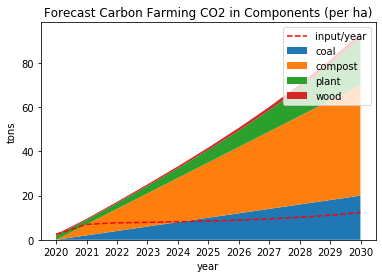

In [171]:
fig = plt.figure()

ax = fig.add_subplot(1,1,1)
ax.stackplot(df['year'],df['coal'],df['compost'],df['plant'],df['wood'])

ax.plot(df['year'],df['delta'],color='red', linestyle='dashed')
ax.set_title('Forecast Carbon Farming CO2 in Components (per ha)')
ax.set_ylabel('tons')
ax.set_xlabel('year')
ax.legend(['input/year','coal','compost','plant','wood'])

plt.show()

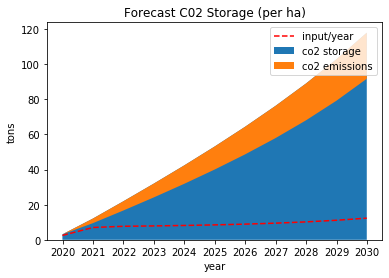

In [172]:
fig = plt.figure()
ax2 = fig.add_subplot(1,1,1)
ax2.stackplot(df['year'],df['co2 storage'],df['co2 emissions'])

ax2.plot(df['year'],df['delta'],color='red', linestyle='dashed')

ax2.set_title('Forecast C02 Storage (per ha)')
ax2.set_ylabel('tons')
ax2.set_xlabel('year')

ax2.legend(['input/year','co2 storage','co2 emissions'])
plt.show()